<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Exploration/%5BE-08%5D%EC%9D%B8%EB%AC%BC%EC%82%AC%EC%A7%84%EB%AA%A8%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 목차
- 들어가며, 인물사진 모드란?

- 셸로우 포커스 만들기 (1) 사진을 준비하자

- 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

- 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

- 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

- 셸로우 포커스 만들기 (5) 배경 흐리게 하기

- 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

# 1.인물사진 모드란?

핸드폰 카메라의 인물사진 모드는 듀얼 카메라를 이용해 DSLR의 아웃포커싱 기능을 흉내 냅니다. 물론 인물사진의 아웃포커싱 구현은 DSLR의 아웃포커싱 구현과는 다릅니다.

**DSLR**에서는 사진을 촬영할 때 [피사계 심도(depth of field, DOF)](https://ko.wikipedia.org/wiki/%ED%94%BC%EC%82%AC%EA%B3%84_%EC%8B%AC%EB%8F%84)를 얕게 하여 초점이 맞은 피사체를 제외한 배경을 흐리게 만듭니다.

**핸드폰 인물사진 모드**는 화각이 다른 두 렌즈를 사용합니다. 일반(광각) 렌즈에서는 배경을 촬영하고 망원 렌즈에서는 인물을 촬영한 뒷배경을 흐리게 처리한 후 망원 렌즈의 인물과 적절하게 합성합니다.

👉 오늘 만들어볼 목표는 **핸드폰 인물사진 모드**입니다. 사실 핸드폰 인물 사진 모드를 정확히 따라 하기 위해서 2개의 렌즈가 필요하지만 **딥러닝을 적용해서 하나의 렌즈만으로** 비슷하게 흉내 내 보겠습니다.

<br>

---

<br>

### **인물사진 모드에서 사용되는 용어**
한국에서는 배경을 흐리게 하는 기술을 주로 '아웃포커싱'이라고 표현합니다. 하지만 아웃포커싱은 한국에서만 사용하는 용어이고 정확한 영어 표현은 **얕은 피사계 심도(shallow depth of field)** 또는 **셸로우 포커스(shallow focus)** 라고 합니다. 또한 **보케(bokeh)**라는 일본어에서 유래된 표현 또한 많이 사용합니다. 

# 2.Shallow Focus 만들기

## (1)사진준비

### **하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법**
두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 합니다. **이미지 세그멘테이션(image segmentation) 기술**을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있습니다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있습니다.

<br>

**따라서 우리는 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 겁니다.**

1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성합니다.

<br>

### **사진 준비**
**urllib** 패키지는 웹에서 데이터를 다운로드할 때 사용합니다.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
img_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/sehui2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1279, 1279, 3)


## (2)Segmentation으로 사람 분리하기

배경에만 렌즈 흐림 효과를 주기 위해서 그림과 같이 **이미지에서 사람과 피사체를 분리**해야 합니다. 흔히 포토샵으로 **'누끼 따기'**라는 것이 바로 이런 작업을 말합니다

<br>

###  **세그멘테이션(Segmentation)이 뭔가요?**
이미지 세그멘테이션(Image Segmentation): 이미지에서 픽셀 단위로 원하는 객체를 추출하는 방법
- 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다.
- 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠.
-물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

<br>

### 1) Semantic Segmentation
세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 **물리적 의미 단위**로 인식하는 세그멘테이션을 **시맨틱 세그멘테이션(Semantic Segmentation)**이라고 합니다.

쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하면 됩니다. 이것이 오늘 다룰 세그멘테이션 방법이다.

<br>

### 2) Instance Segmentation
semantic 세그멘테이션은 '사람'이라는 **추상적인 정보를 이미지에서 추출**해내는 방법입니다. 그래서 사람이 누구인지 관계없이 **같은 라벨로 표현**이 됩니다.

더 나아가서 **인스턴스 세그멘테이션(Instace Segmentaion)**은 **사람 개개인별로 다른 라벨**을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.

<br>

> *Q. Instance Segmentation 데이터셋과 라벨이 존재하면 Sementic Segmentation을 학습시킬 수 있을까요?*<br><br>
인스턴스의 id 뿐만이 아닌 **클래스 라벨**이 존재해야 시맨틱 세그멘테이션으로 학습이 가능합니다. 근본적으로는 다른 개념이지만 대부분의 데이터셋은 인스턴스 라벨이 있는 경우 클래스 라벨도 함께 존재합니다.

<br>

### 3) Watershed Segmentation
워터쉐드 세그멘테이션(Watershed Segmentation)은 딥러닝에 기반한 방법 이전의 이미지 세그멘테이션 방법이다.

이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것입니다. 이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가집니다.

픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있습니다.

낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다.

그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다.

## (3)Semantic Segmentation 다루기

세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됩니다. 오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력하겠습니다. [**DeepLab 알고리즘**](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있습니다.

<br>

Q. DeepLab에서 atrous convolution을 사용한 이유가 무엇인가요?
> receptive field를 넓게 사용하기 위해 사용합니다. (적은 파라미터로 필터가 더 넓은 영역을 보게 하기 위해)

Q. Depthwise separable convolution은 어디서 처음 사용한 것 일까요? 왜 이 구조가 효율적일까요?
> Xception 에서 제안되었습니다. 3x3 conv layer 의 receptive field를 1/9 수준의 파라미터로 구현할 수 있기 때문에 효율적입니다.

<br>

DeepLab 모델을 준비하겠습니다. 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수입니다. <br>먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리 합니다.

모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정합니다.

전처리된 이미지는 run() 함수에서 입력값으로 사용되는 것을 볼 수 있습니다.

<br>

> 이번 노드에서는 구글에서 Tensorflow V1으로 작성한 DeepLab 모델 구조를 그대로 가져와 활용하면서,
Tensorflow V2에서 V1 코드와 모델 구조를 활용할 수 있도록 제공하는 tf.compat.v1를 활용하고 있습니다.
그래서 다소 생소할 수 있는 session, graph, feed_dict 등 Tensorflow V2에서는 Model, Input 등에 감추어져 있는 구조가 위 코드에 드러나 있습니다.
Tensorflow V1에서 작성된 수많은 레거시 코드들을 활용하려면 어떻게 해야 하는지를 학습하는 의미에서 Tensorflow V2 코드와 비교해 가면서 보기를 바랍니다.

사전에 학습된 가중치(pretrained weight)를 불러옵니다. 구글에서 제공하는 파일을 다운로드하겠습니다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /root/aiffel/human_segmentation/models
model loaded successfully!


구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화합니다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

<br>

첫 단계에서 준비한 이미지를 네트워크에 입력합니다.<br>
**cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다!**
- img_orig는 원본이미지 크기
- img_resized는 resize한 이미지 크기
- sep_map.max()는 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1279, 1279, 3) (513, 513, 3) 15


우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화해 볼까요?

<br>

사람을 뜻하는 15 외 예측은 0으로 만들었습니다. 그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 됩니다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

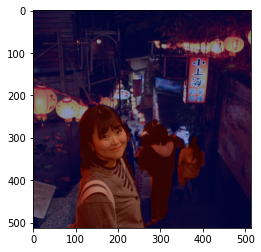

In [6]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## (4)Segmentation 결과를 원래 크기로 복원하기

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. <br>따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.

<br>

cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데요, cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용합니다. 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법입니다.<br>
[참고](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html)

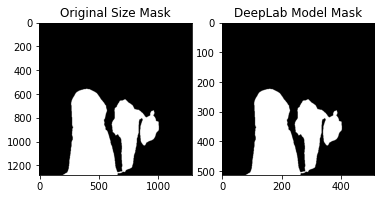

In [7]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## (5) 배경 흐리게 하기

이번에는 배경을 흐리게 만듭니다. blur()함수를 이용합니다.

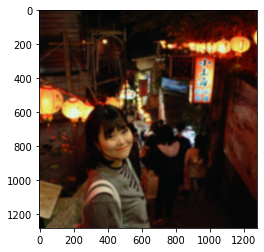

In [8]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

<br>

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.
<br>
[StackOverflow: bitwise_not, bitwise_and 함수를 사용해 이미지 바꾸기](https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask)

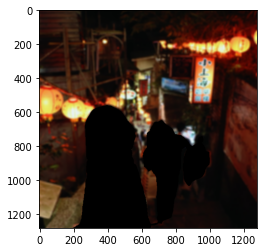

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# (6)흐린 배경과 원본 영상 합성

세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용합니다.

<br>

인물과 배경의 거리차이가 있고 거리가 일정할 수록 더 자연스러워 보인답니다.

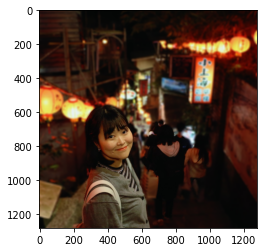

In [10]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()